#  Анализ предобработанных ответов

Мы выделили в ответах набор признаков:
- количество слов, 
- количество слов вне словаря,
- наличие глаголов,
- наличие отрицаний,
- упоминание прошлого или будущего.

Изучим связь этих признаков с ответом на вопрос "Кем ты работаешь?"

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import pymorphy2

In [4]:
import sys
sys.path.append('../')
from src.data.preprocess import drop_stopwords, tokenize_drop_punkt
from src.data.preprocess import spell_check, normalize_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dkharitonov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dkharitonov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
MA = pymorphy2.MorphAnalyzer()

## Загрузка данных

In [6]:
df = pd.read_csv('../datasets/intermediate/df_answers_analysed.csv', index_col=0, low_memory=False)

In [7]:
df.shape

(149700, 141)

In [8]:
columns = ['q61', 'corrected', 'n_out_of_vocab', 'n_words', 
           'n_verbs', 'has_negative', 'has_past_future',
           'tokenized', 'normalized']

## Анализ характеристик ответов

### Нормализованные токены

Оценим, какое количество объектов остались без нормализованных токенов: сузществительных и прилагательных без стоп-слов.

In [9]:
print('Объектов с нормализоваными токенами', df[~df.normalized.isna()].shape[0])
print('Объектов с пустыми нормализоваными токенами', df[df.normalized.isna()].shape[0])

Объектов с нормализоваными токенами 80894
Объектов с пустыми нормализоваными токенами 68806


In [10]:
df[df.normalized.isna()][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
3,никем,никем,0,1,0,1,0,никем,NaN
4,я школьник,я школьник,1,2,0,0,0,школьник,NaN
5,Никем,никем,0,1,0,1,0,никем,NaN
8,никнм,никем,0,1,0,1,0,никем,NaN
9,НЕ КЕМ,не кем,2,2,0,1,0,не кем,NaN


Видим, что нормализация помогает нам выделить ответы, не содержащие смысловых по отношению к профессии терминов.

### Глаголы в ответе

Проанализируем как распределены объекты по количеству глаголов в ответах. Формулировака вопроса "Кем ты работаешь?" не подразумевает наличие глагола. Глагол характерен для ответа "Что ты делаешь?".

In [11]:
df[~df.normalized.isna()].n_verbs.value_counts()

0     79793
1       849
2       194
3        39
4        12
5         4
6         2
10        1
Name: n_verbs, dtype: int64

Действительно, глаголы в ответах встречаются редко: в 1 из 9 случаев.

Посмотрим пример ответов с глаголами.

In [12]:
df[~df.normalized.isna() & (df.n_verbs > 0)][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
1,Данный момент не работаю,данный момент не работаю,1,4,1,1,0,данный момент не работаю,данный момент
573,"Я работаю на предприятии, слежу за работой в з...",я работаю на предприятии слежу за работой в за...,6,16,4,0,0,работаю на предприятии слежу за работой зале и...,зал предприятие упаковка
578,"Четкого названия профессии нет, я смотрю за те...",четкого названия профессии нет я смотрю за тем...,6,19,3,1,0,четкого названия профессии нет смотрю за тем к...,возникновение зал название проблема профессия ...
668,не выбрала профессию,не выбрала профессию,1,3,1,1,0,не выбрала профессию,профессия
754,хотел бы юристом,хотел бы юристом,1,3,1,0,0,хотел бы юристом,юрист


Наличие глагола в ответе говорит о том, что в ответе скорее рассуждение о профессии, нежели непосредственный ответ. 

Примем наличие глагола как признак, говорящий, что ответ не является профессией.

Дальнейший анализ сделаем для ответов без глаголов.

### Отрицание в ответах

Мы видели в ответах отрицательные предлоги и частицы ('не', 'ни', 'без', 'нет'). Посмотрим, сколько объектов с такими ответами.

In [13]:
df[~df.normalized.isna() & (df.n_verbs == 0)].has_negative.value_counts()

0    79580
1      213
Name: has_negative, dtype: int64

Мы видим всего 213 ответов с отрицанием.

In [14]:
df[~df.normalized.isna() & (df.n_verbs == 0) & (df.has_negative == 1)][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
1544,Нет работы на данный момент,нет работы на данный момент,2,5,0,1,0,нет работы на данный момент,данный момент
1762,"пока никем, я - бывший ученик выпускного класса",пока никем я - бывший ученик выпускного класса,2,8,0,1,1,пока никем бывший ученик выпускного класса,бывший выпускной
1791,Никем я ужасный человек,никем я ужасный человек,1,4,0,1,0,никем ужасный человек,ужасный человек
1876,Никем директором,никем директором,0,2,0,1,0,никем директором,директор
2083,Не кеи,не кеи,2,2,0,1,0,не кеи,кея


Действительно видим ответы, говорящие, что респондент не работает.

### Будущее или прошедшее время

In [15]:
df[~df.normalized.isna() & (df.n_verbs == 0) & (df.has_negative == 0)].has_past_future.value_counts()

0    79565
1       15
Name: has_past_future, dtype: int64

In [16]:
(
    df[~df.normalized.isna() 
       & (df.n_verbs == 0) 
       & (df.has_negative == 0) 
       & (df.has_past_future == 1)]
    [columns]
    .head()
)

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
2556,Будущий Юрист,будущий юрист,0,2,0,0,1,будущий юрист,будущий юрист
6464,"Тренер, будущий врач",тренера будущий врач,0,3,0,0,1,тренера будущий врач,будущий врач тренер
6497,Я будущий студент,я будущий студент,1,3,0,0,1,будущий студент,будущий
14642,будущий специалист по рекламе и связям с общес...,будущий специалист по рекламе и связям с общес...,3,8,0,0,1,будущий специалист по рекламе связям обществен...,будущий общественность реклама связь специалист
33312,Будущий врач,будущий врач,0,2,0,0,1,будущий врач,будущий врач


Видим, что прошлое или будещее время говорит, что ответ не про текущую профессию.

### Слова не из словаря

Следующий выделенный для ответов признак говорит о количестве слов в ответе, которые не нашлись (функция ```spell_check``` модуля [```preprocess```](../src/data/preprocess.py)). Под "не нашлись" мы понимем слова длиной три символа и меньше, либо слова, которые не найдены [в словаре профессий](create_dictionary.ipynb)

In [17]:
(
    df[~df.normalized.isna() 
       & (df.n_verbs == 0) 
       & (df.has_negative == 0) 
       & (df.has_past_future == 0)]
    .n_out_of_vocab
    .value_counts()
)

0    68400
1     9673
2     1387
3       88
4       11
5        3
9        1
6        1
7        1
Name: n_out_of_vocab, dtype: int64

Видим, что наличие одного слова вне словаря распространненное явление. Посмотрим на примеры с одним словом вне словаря.

In [18]:
(
    df[~df.normalized.isna() 
    & (df.n_verbs == 0) 
    & (df.has_negative == 0) 
    & (df.has_past_future == 0)
    & (df.n_out_of_vocab == 1)][columns]
    .head()
)

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
30,методист по культурно просветительной работе,методист по культурно просветительной работе,1,5,0,0,0,методист по культурно просветительной работе,методист просветительный
48,Инженер по охране труда,инженер по охране труда,1,4,0,0,0,инженер по охране труда,инженер охрана труд
54,Авиадиспетчер,авиадиспетчер,1,1,0,0,0,авиадиспетчер,авиадиспетчер
61,Оперуполномоченный,оперуполномоченный,1,1,0,0,0,оперуполномоченный,оперуполномоченный
122,На складе,на складе,1,2,0,0,0,на складе,склад


Видим, что в таких ответах употребляются предлоги и частицы, либо редкие профессии (авиадиспетчер, оперуполномоченный), которые отстутвуют в словаре. При этом ответы качественные.

In [19]:
(
    df[~df.normalized.isna() 
    & (df.n_verbs == 0) 
    & (df.has_negative == 0) 
    & (df.has_past_future == 0)       
    & (df.n_out_of_vocab == 2)][columns]
    .head()
)

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
379,Младший специалист в Яндекс.Такси,младший специалист в яндекс.такси,2,4,0,0,0,младший специалист яндекс.такси,младший специалист яндекс.такси
402,консультант в кол центре,консультант в кол центре,2,4,0,0,0,консультант кол центре,кол консультант центр
465,Специалист по связям с общественностью,специалист по связям с общественностью,2,5,0,0,0,специалист по связям общественностью,общественность связь специалист
487,инженер-менеджер по управлению качеством,инженер-менеджер по управлению качеством,2,4,0,0,0,инженер-менеджер по управлению качеством,инженер-менеджер качество управление
755,Специалист по контролю за персоналом,специалист по контролю за персоналом,2,5,0,0,0,специалист по контролю за персоналом,контроль персонал специалист


Для двух слов вне словаря видим ситуацию, аналогичную одному слову.

In [20]:
(
    df[~df.normalized.isna() 
    & (df.n_verbs == 0) 
    & (df.has_negative == 0) 
    & (df.has_past_future == 0)
    & (df.n_out_of_vocab == 3)][columns]
    .head()
)

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
3619,Главный специалист в отделе по работе с персон...,главный специалист в отделе по работе с персон...,3,8,0,0,0,главный специалист отделе по работе персоналом,главный персонал специалист
6235,Представитель автошколы в ГАИ,представитель автошколы в гаи,3,4,0,0,0,представитель автошколы гаи,автошкола гаи представитель
7177,Слесарь по КИПиА,слесарь по контрольно-измерительные приборы и ...,3,6,0,0,0,слесарь по контрольно-измерительные приборы ав...,автоматика контрольно-измерительный прибор сле...
9043,Лаборант в научной лаборатории и уборщик в школе,лаборант в научной лаборатории и уборщик в школе,3,8,0,0,0,лаборант научной лаборатории уборщик школе,лаборант лаборатория научный уборщик
9778,Младшая медицинская сестра по уходу за больным...,младшая медицинская сестра по уходу за больным...,3,9,0,0,0,младшая медицинская сестра по уходу за больным...,больной инвалид медицинский младший сестра уход


Для трех слов вне словаря ответы становятся сложнее, содержат дополенния и уточнения. 

In [21]:
(
    df[~df.normalized.isna() 
    & (df.n_verbs == 0) 
    & (df.has_negative == 0) 
    & (df.has_past_future == 0)
    & (df.n_out_of_vocab > 3)][columns]
    .head()
)

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
24129,Я ШКОЛЬНИК МНЕ 14 АЛО,я школьник мне 14 ало,4,5,0,0,0,школьник мне 14 ало,ало
24981,зам зав по ахр,зам зав по ахр,4,4,0,0,0,зам зав по ахр,ахра зав зам
25039,"продавцом, мастером по роботам пылесосам, по ...","продавцом мастером по работам пылесосам, по пы...",9,17,0,0,0,продавцом мастером по работам пылесосам по пыл...,бытовой мастер машина мелкий посудомоечный про...
28994,Автор и создатель клуба для м и ж,автор и создатель клуба для м и ж,5,8,0,0,0,автор создатель клуба для,автор клуб создатель
40161,Шадоуфинд гуль ссс ранга zxc 1000-7,шадоуфинд гуль ссс ранга zxc 1000-7,4,6,0,0,0,шадоуфинд гуль ссс ранга zxc 1000-7,гуля ранг шадоуфинда


Начаиня с 4 слов вне словаря ответы начинаю быть менее осмысленные или явно не подходящие. 

### Количество слов в ответе

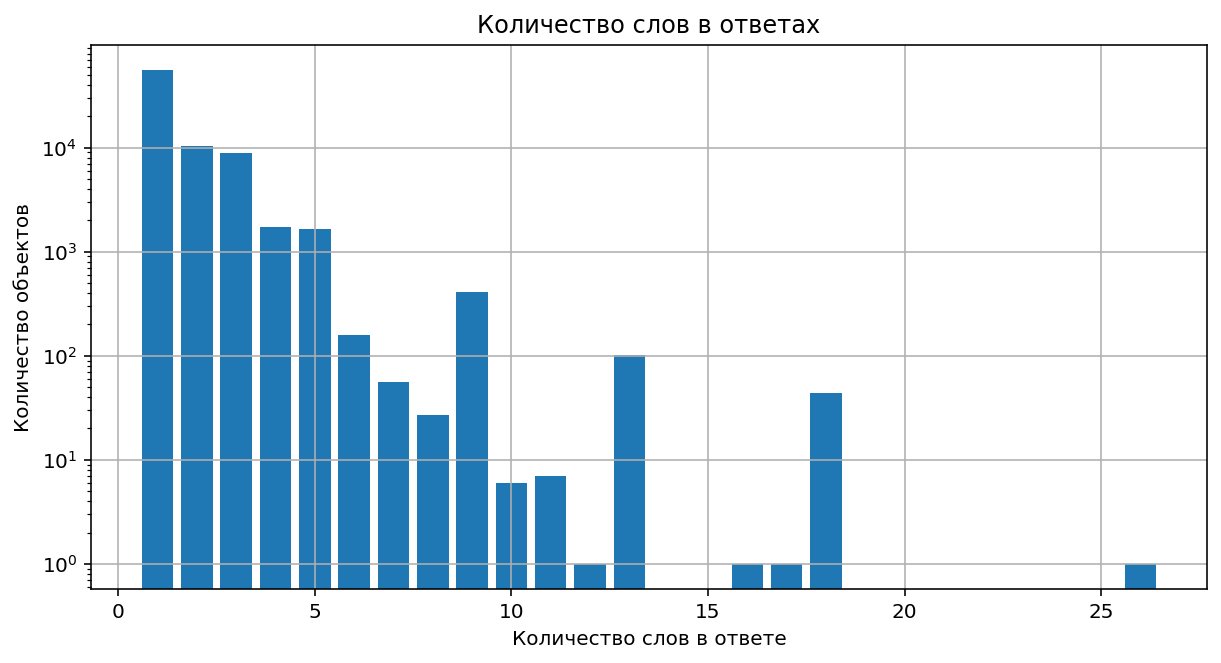

In [22]:
plot_data = df[~df.normalized.isna() 
               & (df.n_verbs == 0) 
               & (df.has_negative == 0) 
               & (df.has_past_future == 0)
              ].n_words.value_counts().reset_index().sort_values(by='index')
plt.figure(figsize=(10,5))
plt.bar(x=plot_data['index'], height=plot_data['n_words'], log=True)
plt.grid(visible=True)
plt.xlabel('Количество слов в ответе')
plt.ylabel('Количество объектов')
plt.title('Количество слов в ответах')
plt.show()

In [23]:
df[~df.normalized.isna() 
   & (df.n_verbs == 0) 
   & (df.has_negative == 0)
   & (df.has_past_future == 0)
   & (df.n_words > 8)][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
5509,Учитель музыки в школе музыкальный руководите...,учитель музыки в школе музыкальный руководител...,2,9,0,0,0,учитель музыки школе музыкальный руководитель ...,детский музыка музыкальный руководитель сад уч...
9778,Младшая медицинская сестра по уходу за больным...,младшая медицинская сестра по уходу за больным...,3,9,0,0,0,младшая медицинская сестра по уходу за больным...,больной инвалид медицинский младший сестра уход
17180,Машинист насосной станции по закачке рабочего ...,машинист насосной станции по закалке рабочего ...,3,11,0,0,0,машинист насосной станции по закалке рабочего ...,агент закалка машинист насосный пласт рабочий ...
23998,руководитель направления по операционному серв...,руководитель направления по операционному серв...,3,9,0,0,0,руководитель направления по операционному серв...,банк качество направление операционный руковод...
25039,"продавцом, мастером по роботам пылесосам, по ...","продавцом мастером по работам пылесосам, по пы...",9,17,0,0,0,продавцом мастером по работам пылесосам по пыл...,бытовой мастер машина мелкий посудомоечный про...


Ответы с большим количеством слов характерны для подробного описания профессии. 

In [38]:
df.to_csv('../datasets/intermediate/df_is_profession.csv', index=False)

### Выводы

Выделенные из ответов признаки позволяют сделать предположение о том, является ли ответ профессией.

Если в ответе:
- нет нормализованных токенов
- есть глаголы
- есть отрицания
- есть упоминание прошлого или будущего
- 4 и более слов вне словаря профессий
такой ответ не является профессией.

## Анализ ответов с профессиями

### Сравнение ответов с профессиями и не профессиями

Добавим признак "профессия" к датасету.

In [24]:
df['is_profession'] = (~df.normalized.isna()\
                       & (df.n_verbs == 0)\
                       & (df.has_negative == 0)\
                       & (df.has_past_future == 0)\
                       & (df.n_out_of_vocab < 4))

In [25]:
df[~df.is_profession][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
1,Данный момент не работаю,данный момент не работаю,1,4,1,1,0,данный момент не работаю,данный момент
3,никем,никем,0,1,0,1,0,никем,NaN
4,я школьник,я школьник,1,2,0,0,0,школьник,NaN
5,Никем,никем,0,1,0,1,0,никем,NaN
8,никнм,никем,0,1,0,1,0,никем,NaN


In [26]:
df[df.is_profession][columns].head()

,q61,corrected,n_out_of_vocab,n_words,n_verbs,has_negative,has_past_future,tokenized,normalized
0,экономист,экономист,0,1,0,0,0,экономист,экономист
2,Учитель,учитель,0,1,0,0,0,учитель,учитель
6,рекламист,рекламы,0,1,0,0,0,рекламы,реклама
7,Руководитель участка,руководитель участка,0,2,0,0,0,руководитель участка,руководитель
11,Повар,повар,0,1,0,0,0,повар,повар


Визуально разделение выглядит корректным.

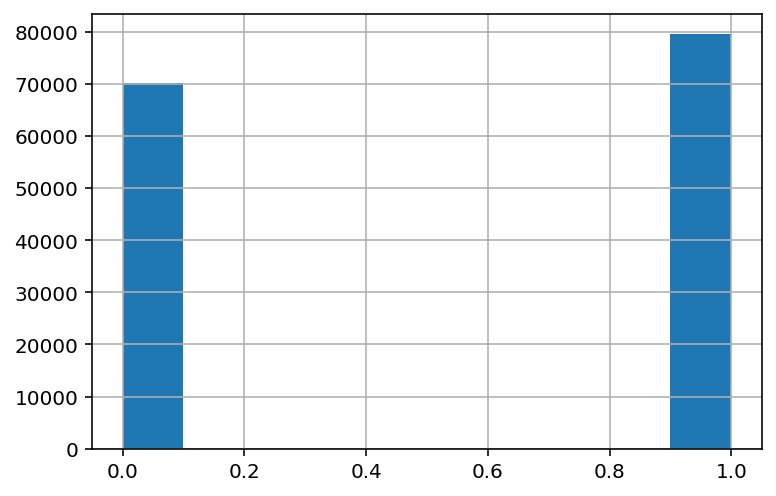

In [27]:
df.is_profession.astype('int').hist()
plt.show()

Чуть менее половины ответов не относится к профессиям.

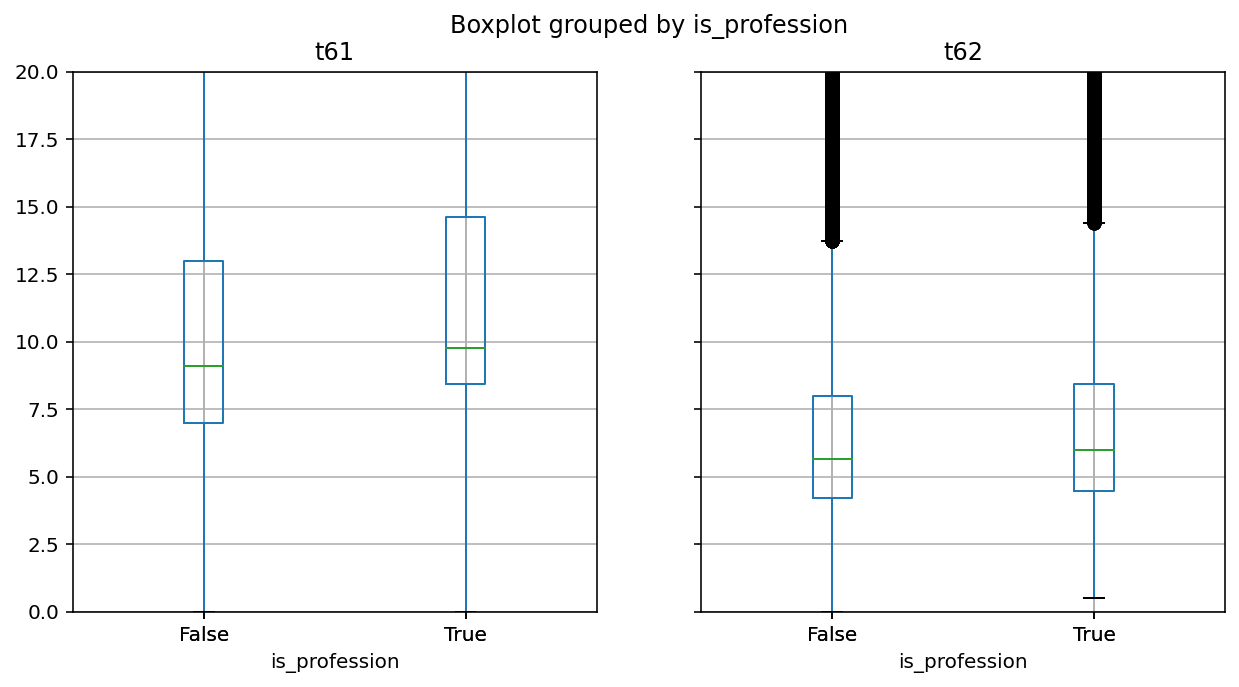

In [28]:
df.boxplot(column=['t61', 't62'], by='is_profession', figsize=(10,5))
plt.ylim(0, 20)
plt.show()

Время ответа на вопрос "Кем ты работаешь" (t61) и "Позволяет ли работа тебе самореализоваться?" (t62) слабо зависит от того, работает респондент сейчас или нет. 

<AxesSubplot:>

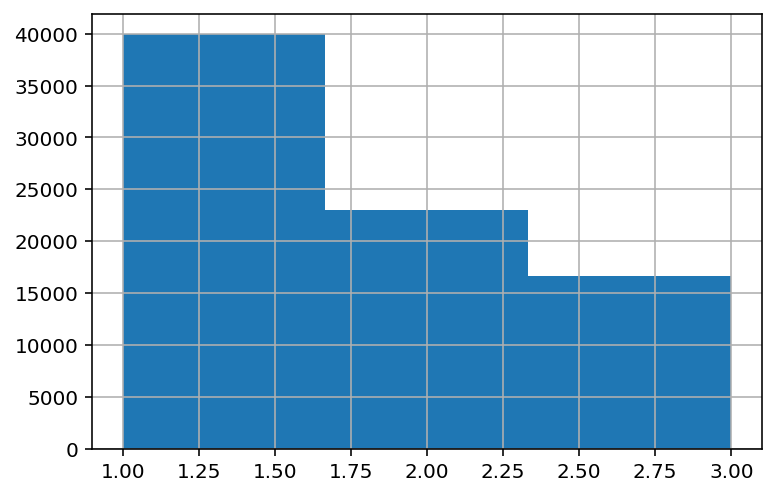

In [29]:
df[df.is_profession].q62.hist(bins=3)

<AxesSubplot:>

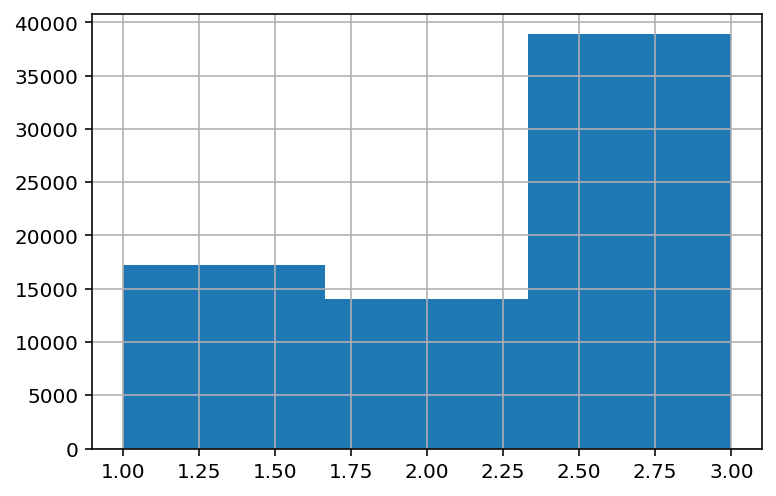

In [30]:
df[~df.is_profession].q62.hist(bins=3)

Распределения ответов на вопрос "Позволяет ли работа тебе самореализоваться?" (q62) для работающих и не работающих противоположные: среди работающих большинство может реализоваться, среди неработающих наоборот.

### Количество уникальных значений токенов

In [31]:
professions = df[df.is_profession]

In [32]:
source_distribution = professions.q61.str.lower().value_counts().reset_index()

In [33]:
target_distribution = professions.normalized.value_counts().reset_index()

In [34]:
print('Уникальных значений в исходных ответах с профессиями', len(source_distribution))
print('Уникальных значений нормализованных токенов', len(target_distribution))

Уникальных значений в исходных ответах с профессиями 12885
Уникальных значений нормализованных токенов 7448


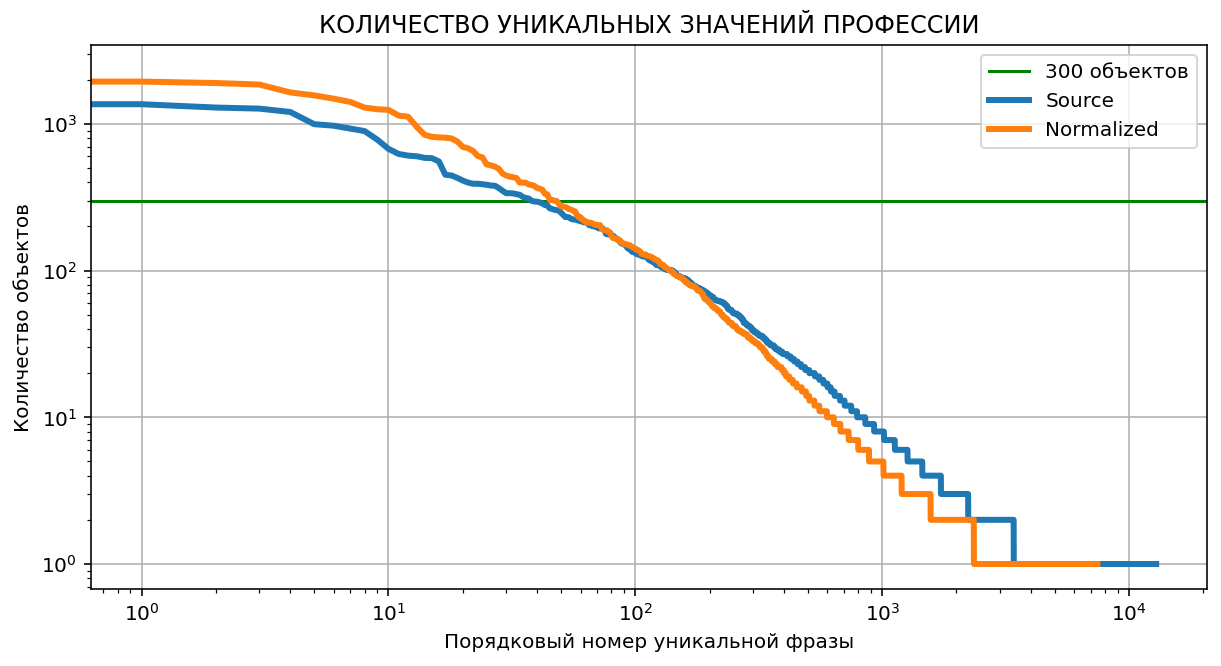

In [36]:
plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xscale('log')
plt.axhline(300, c='g', label='300 объектов')
plt.plot(source_distribution.index, source_distribution['q61'], label='Source', lw=3)
plt.plot(target_distribution.index, target_distribution['normalized'], label='Normalized', lw=3)
plt.ylabel('Количество объектов')
plt.xlabel('Порядковый номер уникальной фразы')
plt.title('Количество уникальных значений профессии'.upper())
plt.legend()
plt.grid(visible=True)
plt.show()

Нормализация увеличила количество профессий, для который есть более 300 объектов.

## Вывод

Мы определили правла для бинарной классификации ответов "профессия" или "не профессия".

Убедились, что нормализация токенов увеличила количество профессий, для которых колчиесвто объектов большее 300.